In [1]:
# this is just for fun
# the raw daily percent values are the only real data (maybe)
# percentage values taken from https://covid19tracker.ca/vaccinationtracker.html manually
# updated at arbitrary times
# (I need some way to keep busy)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit


In [2]:

# dates on which percentages are achieved (to nearest percent/day)
dates = pd.Series(['14 Jan 2021','27 Jan 2021','24 Feb 2021','4 Mar 2021','9 Mar 2021','12 Mar 2021','16 Mar 2021','19 Mar 2021','22 Mar 2021','25 Mar 2021','27 Mar 2021','29 Mar 2021', '31 Mar 2021','3 Apr 2021','5 Apr 2021','7 Apr 2021'])


percent = np.arange(1,len(dates)+1) # percentage of first doses received per population
print('Last updated: {}, for {}% vaccinated'.format(dates.iloc[-1],percent[-1]))

dates = pd.to_datetime(dates)
# print(dates)

d = {'dates':pd.Series(dates),'percent': pd.Series(percent)}

df = pd.DataFrame(d)

# date difference from first day; for fitting
df['date_diff'] = df['dates']-df['dates'][0]

# df['date_diff'].dt.days.values

day_diff = df['date_diff'].dt.days.values[1:] - df['date_diff'].dt.days.values[:-1]

Last updated: 7 Apr 2021, for 16% vaccinated


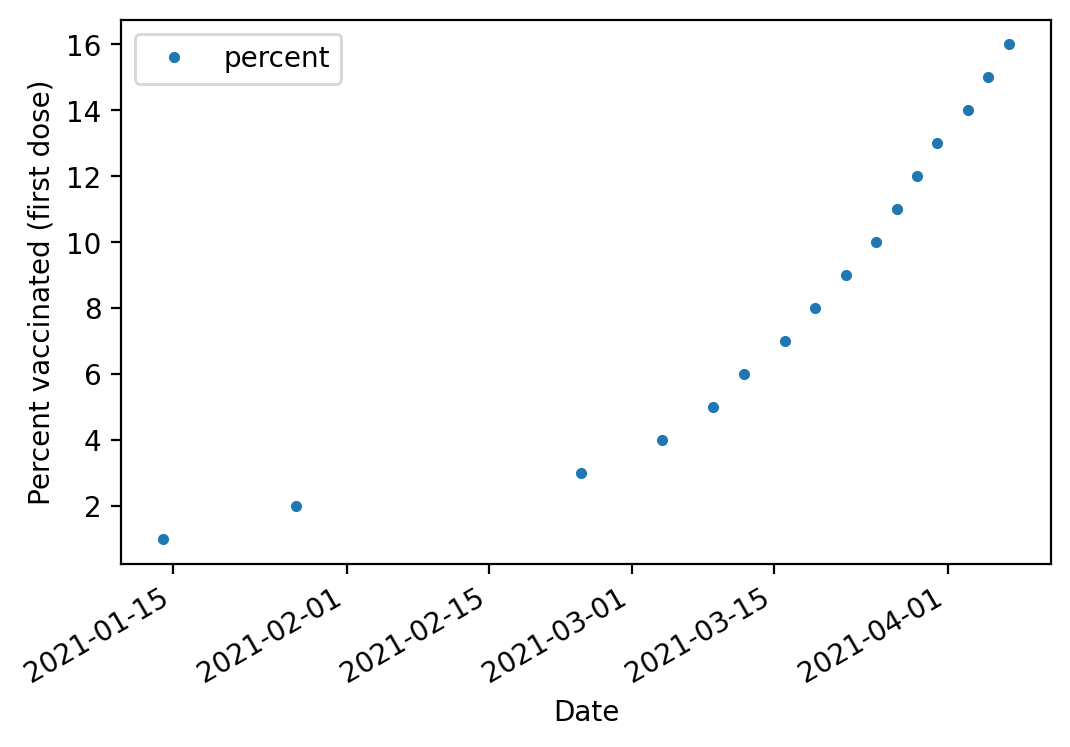

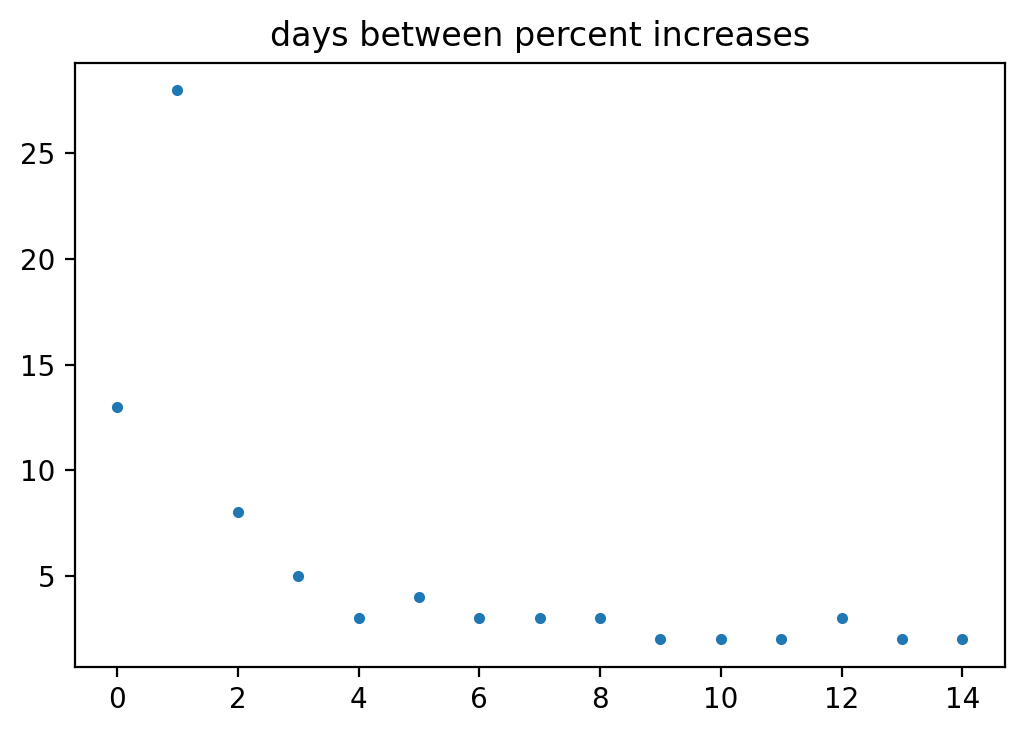

In [3]:
plt.figure(dpi=200)
df.plot(x='dates', y='percent', style='.', ax=plt.gca())
plt.ylabel('Percent vaccinated (first dose)')
plt.xlabel('Date')
plt.show()

plt.figure(dpi=200)
plt.plot(day_diff,'.')
plt.title('days between percent increases')
plt.show()

In [4]:
def exp_func(x, a, b, c):
    return a*np.exp(b*x) + c

def lin_func(x,a,b):
    return a*x + b

In [5]:
x = df['date_diff'].dt.days.values
y = df['percent'].values

print(x)
print(y)

y2 = np.log(y)

# first do linear fit (converges easily)
popt, pcov = curve_fit(lin_func, x, y2)
# use values from linear fit as initial guess for exp fit (otherwise doesn't converge properly)
popt2, pcov2 = curve_fit(exp_func, x, y, p0=[popt[0], popt[1], 0.5])#,sigma=0.5*np.ones(len(x)))

# 1 day previous
popt3, pcov3 = curve_fit(exp_func, x[:-1], y[:-1], p0=[popt[0], popt[1], 0.5])
# # 2 days previous
# popt4, pcov4 = curve_fit(exp_func, x[:-2], y[:-2], p0=[popt[0], popt[1], 0.5])

# exclude first day
popt5, pcov5 = curve_fit(exp_func, x[1:],y[1:],p0=[popt[0],popt[1],0.5])

[ 0 13 41 49 54 57 61 64 67 70 72 74 76 79 81 83]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [6]:
popt, popt2, popt3#, popt4 #pcov, pcov2



(array([ 0.03292043, -0.01914161]),
 array([0.56282527, 0.04032878, 0.44954108]),
 array([0.49269686, 0.04205732, 0.58211171]))

In [7]:
# create dates for x-values for fit so that they can be plotted on the plot with the datetime axis 
#(otherwise matplotlib complains)
x2 = pd.date_range(start='2021/01/14', periods=300)
print(x2)
x2_fit = np.arange(300)

# linear fit in log space; take exponential
y_fit = np.exp(lin_func(x2_fit, popt[0], popt[1]))
# exponential fit
y_fit_2 = exp_func(x2_fit, popt2[0], popt2[1], popt2[2])

y_fit_prev = exp_func(x2_fit, popt3[0],popt3[1],popt3[2])

# y_fit_prev_2 = exp_func(x2_fit, popt4[0],popt4[1],popt4[2])

y_fit_excl1 = exp_func(x2_fit, popt5[0],popt5[1],popt5[2])

DatetimeIndex(['2021-01-14', '2021-01-15', '2021-01-16', '2021-01-17',
               '2021-01-18', '2021-01-19', '2021-01-20', '2021-01-21',
               '2021-01-22', '2021-01-23',
               ...
               '2021-10-31', '2021-11-01', '2021-11-02', '2021-11-03',
               '2021-11-04', '2021-11-05', '2021-11-06', '2021-11-07',
               '2021-11-08', '2021-11-09'],
              dtype='datetime64[ns]', length=300, freq='D')


(16, 3)
1 days 00:00:00


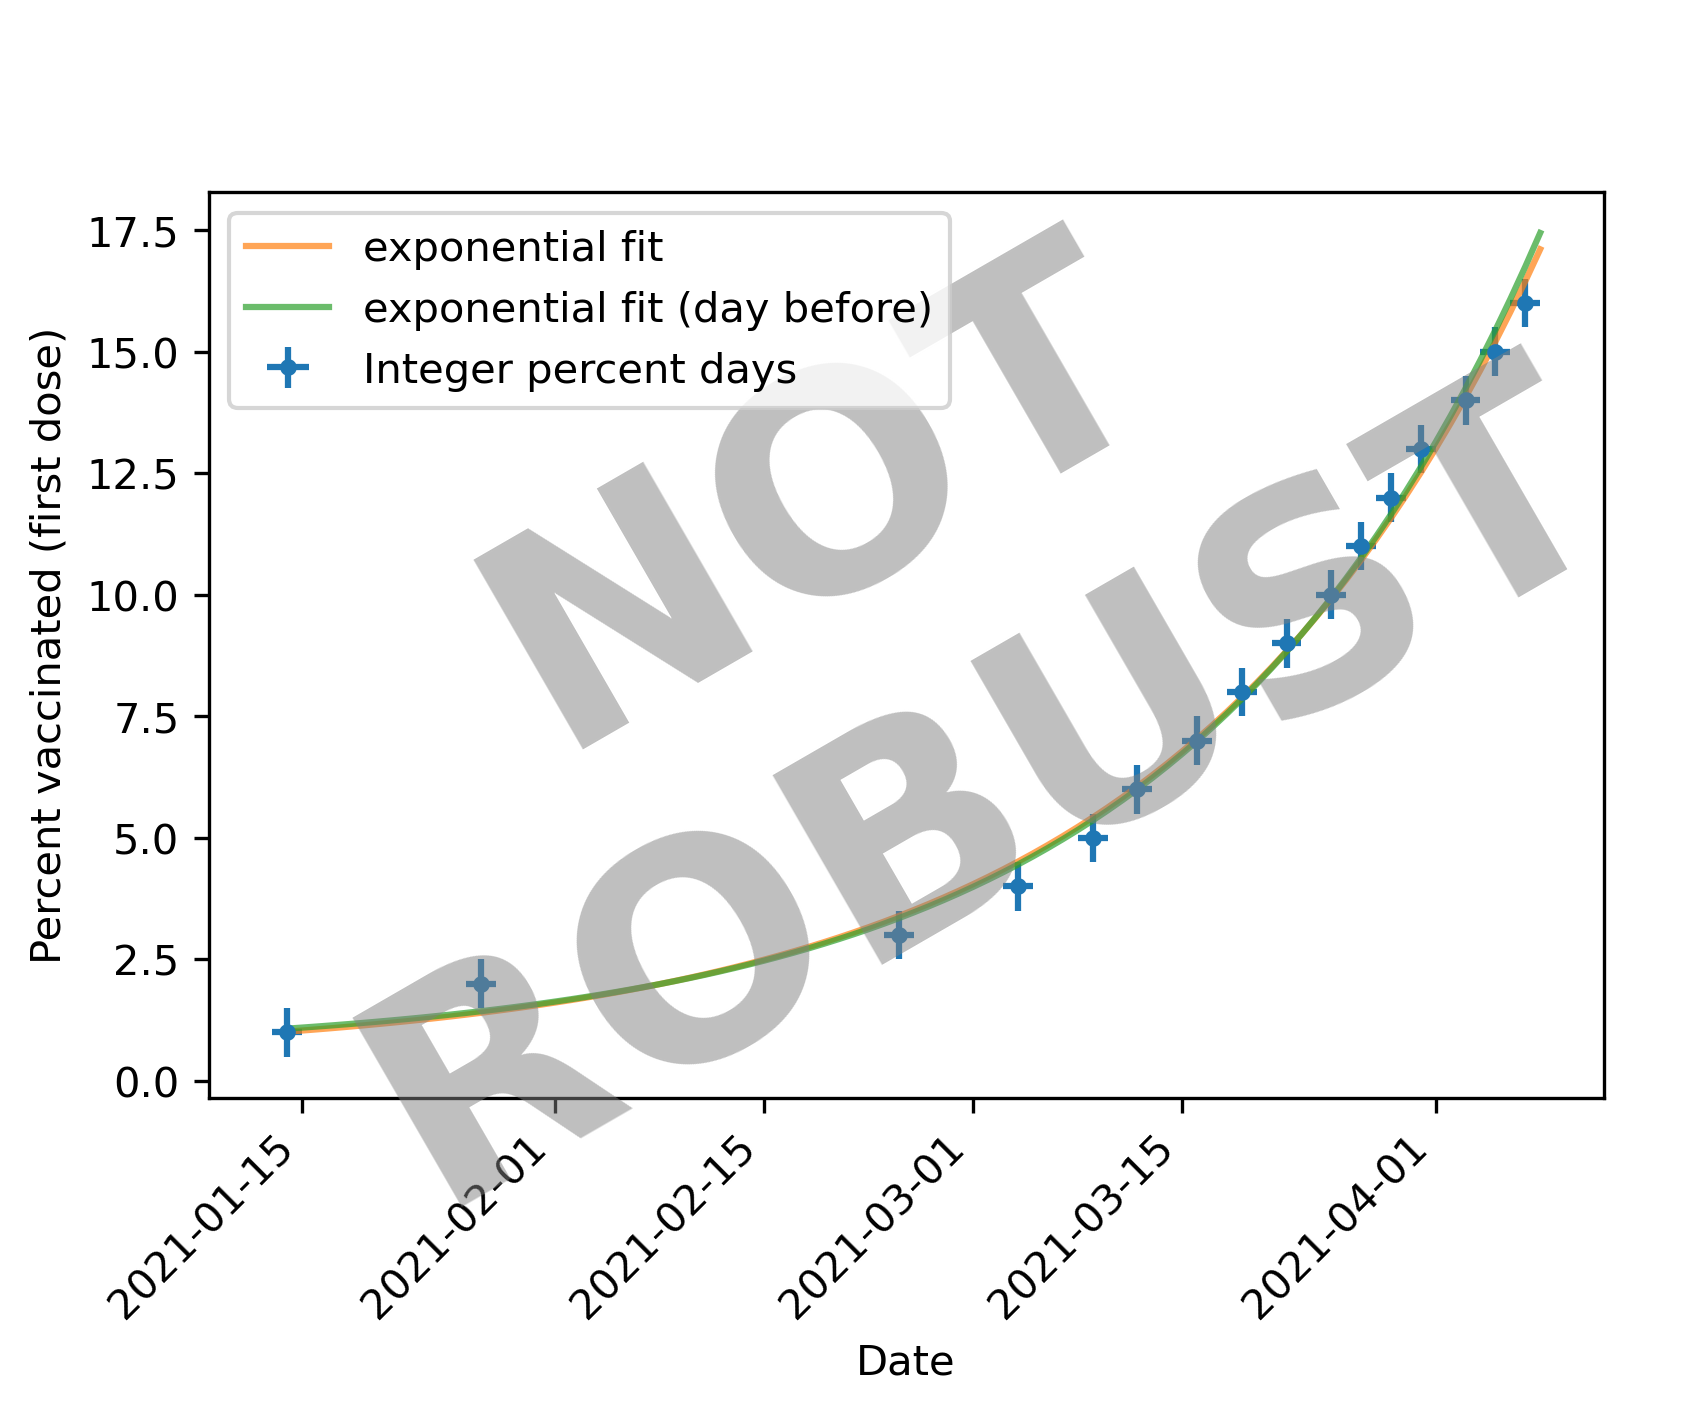

In [11]:

lim = 85
print(df.shape)

terr = pd.Timedelta(hours=24)
print(terr)

fig = plt.figure(dpi=300)
# df.plot(x='dates', y='percent', style='.',ax=plt.gca())
plt.errorbar(df['dates'].values, df['percent'].values, yerr=0.5,xerr=terr,fmt='.',label='Integer percent days')
#plt.plot(x2[:lim], y_fit[:lim], label='linear fit to log')
plt.plot(x2[:lim], y_fit_2[:lim], alpha=0.7, label='exponential fit')
plt.plot(x2[:lim], y_fit_prev[:lim], alpha=0.7, label='exponential fit (day before)')
# plt.plot(x2[:lim], y_fit_prev_2[:lim], alpha=0.7, label='exponential fit (2 days before)')
# plt.plot(x2[:lim],np.ones(len(x2[:lim]))*10)
# plt.plot(x2[:lim], y_fit_excl1[:lim], alpha=0.7, label='exponential fit (excl. day 1)')
plt.xticks(rotation=45,ha='right')
plt.ylabel('Percent vaccinated (first dose)')
plt.xlabel('Date')
ax = plt.gca()
plt.legend()
ax.text(0.5, 0.5, 'NOT\nROBUST', transform=ax.transAxes,
        fontsize=72, color='gray', alpha=0.5,
        ha='center', va='center', rotation='30',fontweight='bold')
# plt.savefig('fit_{}_percent'.format(percent[-1]))
plt.show()


In [9]:
# predict next percent based on exponential fit (extremely speculative)

next_percent = percent[-1]+1

idx_next = np.argmin(np.abs(y_fit_2 - next_percent))

date_next = x2[idx_next]
print("The current predicted date for {}% of the population having received at least 1 dose is {} +/- 1 day".format(next_percent, date_next))

The current predicted date for 17% of the population having received at least 1 dose is 2021-04-08 00:00:00 +/- 1 day


In [10]:
# wishful thinking
idx_100 = np.argmin(np.abs(y_fit_2 - 100))
date_100 = x2[idx_100]
print("100% of the population will (probably not) have received at least one dose by {} (you wish)".format(date_100))

100% of the population will (probably not) have received at least one dose by 2021-05-22 00:00:00 (you wish)
